In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch as th
import cmasher as cmr
from tqdm import tqdm
import copy
from functorch import hessian
import os
import seaborn

os.makedirs("img", exist_ok=True)
seaborn.set_style('whitegrid')
cmap = cmr.get_sub_cmap('plasma', 0.01, 1.)

import matplotlib as mpl

mpl.rcParams["axes.titlesize"] = 14.
mpl.rcParams["axes.labelsize"] = 12.
mpl.rcParams["font.size"] = 12.
mpl.rcParams["axes.titleweight"] = "bold"
mpl.rcParams["axes.labelweight"] = "normal"
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.serif'] = ['cm']
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['font.serif'] = ['CMU']

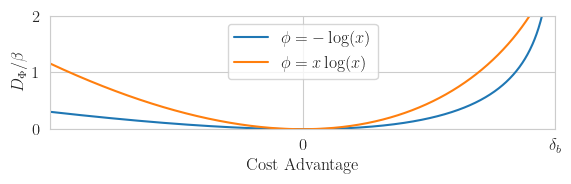

In [3]:
limit = 3

def d_c_barrier(x):
    return (limit-x)/limit - np.log((limit-x)/limit) - 1

def d_c_entropy(x):
    return x - (limit-x)*np.log(limit/(limit-x))

_, ax = plt.subplots(1, 1, figsize=(6, 2))

x = np.linspace(-limit, limit-1e-6, 1000)
ax.plot(x, d_c_barrier(x), label=r"$\phi=-\log(x)$")
ax.plot(x, d_c_entropy(x), label=r"$\phi=x\log(x)$")
ax.set_xlim(-limit, limit)
ax.set_ylim(0, 2)

ax.set_xticks([-limit, 0., limit])
ax.set_xticklabels(["", "0", r"$\delta_b$"])

ax.set_xlabel(r"Cost Advantage")
ax.set_ylabel(r"$D_\Phi/\beta$")

ax.legend()

plt.tight_layout()

plt.savefig("img/div_advantage.pdf")

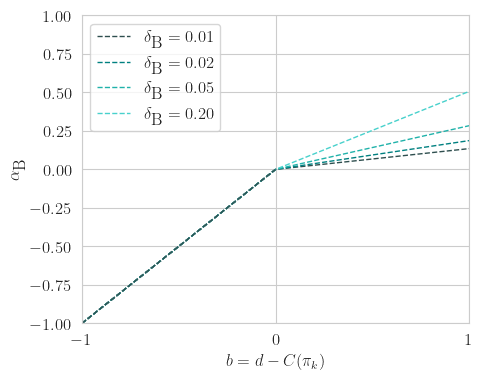

In [14]:
from scipy.special import lambertw
import math

_, axs = plt.subplots(1, 1, figsize=(5, 4))

def budget_function(b, alpha):
    x = b*(lambertw(-np.exp(-alpha-1))+1)
    return np.minimum(b, x)

def budget_function_2(b, alpha):
    return np.sqrt(2*b*alpha)

x = np.linspace(-1, 1, 500)
for d, c in zip([0.01, 0.02, 0.050, 0.2], ["darkslategrey", "teal", "lightseagreen", "mediumturquoise"]):
    axs.plot(x, budget_function(x, d), label=r"$\delta_\textup{B}={%.2f}$" % d, color=c, linestyle="dashed", linewidth=1)
    axs.plot(np.linspace(-1, 0, 250), np.linspace(-1, 0, 250), color="darkslategrey", linestyle="dashed", linewidth=1)
    #axs.plot(x, budget_function_2(x, alpha), label=r"$B_\alpha(s)$ ($\alpha = %.3f$)" % alpha, color=cmap(alpha), linestyle="solid", linewidth=1)
#x = np.linspace(-1, 1, 1000)
#axs.plot(x, x, label=r"$y=x$", linestyle="solid", color="black", linewidth=1)

axs.legend()
axs.set_xlim(-1, 1)
axs.set_ylim(-1, 1)
axs.set_xlabel(r"$b=d-C(\pi_k)$")
axs.set_ylabel(r"$\alpha_\textup{B}$")
#axs.set_title(r"$\alpha_\textup{B} =  \min\{b, b*(W(\exp(-\delta_\textup{B}-1))+1)\}$")

axs.set_xticks([-1, 0, 
1])
plt.savefig("img/budget_function.pdf")

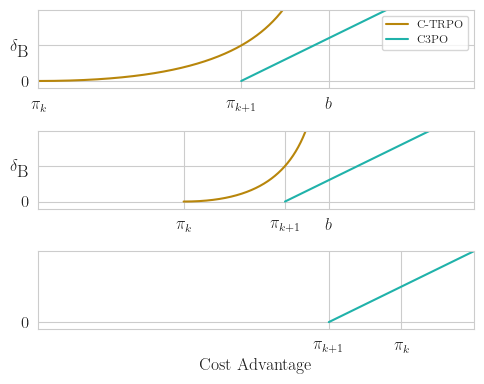

In [27]:
limit = 3
d = 0.5

def d_c_barrier(x):
    return np.log(limit/(limit-x)) - x/limit

def relu(x, a):
    return np.maximum(0, x-a)

_, axs = plt.subplots(3, 1, figsize=(5, 4))

for ax, limit in zip(axs, [2, 1, -0.5]):
    alpha = min(limit, budget_function(limit, d).real)

    if limit > 0:
        x = np.linspace(0, limit-1e-6, 1000)
        ax.plot(x, d_c_barrier(x), label=r"C-TRPO", color="darkgoldenrod")
    else:
        x = np.linspace(0, 0+1e-6, 1000)
        ax.plot(x, np.zeros_like(x), label=r"C-TRPO", color="darkgoldenrod")

    x = np.linspace(alpha, limit+1, 1000)
    ax.plot(x, relu(x, alpha), label=r"C3PO", color="lightseagreen")

    ax.set_xlim(-2+limit, limit+1)
    ax.set_ylim(-0.1, d*2)

    if limit > 0:
        ax.set_xticks([0., alpha, limit])
        ax.set_xticklabels([r"$\pi_k$", r"$\pi_{k+1}$", r"$b$"])
        ax.set_yticks([0, d])
        ax.set_yticklabels([0, r"$\delta_\textup{B}$"])
    else:
        ax.set_xticks([0., alpha])
        ax.set_xticklabels([r"$\pi_k$", r"$\pi_{k+1}$"])
        ax.set_yticks([0])
        ax.set_yticklabels([0])

axs[-1].set_xlabel(r"Cost Advantage")
    #ax.set_ylabel(r"")

axs[0].legend(fontsize=8, loc="upper right")

plt.tight_layout()

plt.savefig("img/moving_barrier.pdf")

/Users/nikola/miniforge3/envs/c3po/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nikola/miniforge3/envs/c3po/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/n1/bxdrmv296493f6tbg9v8pjnh0000gn/T/ipykernel_85192/3806677706.py:95: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


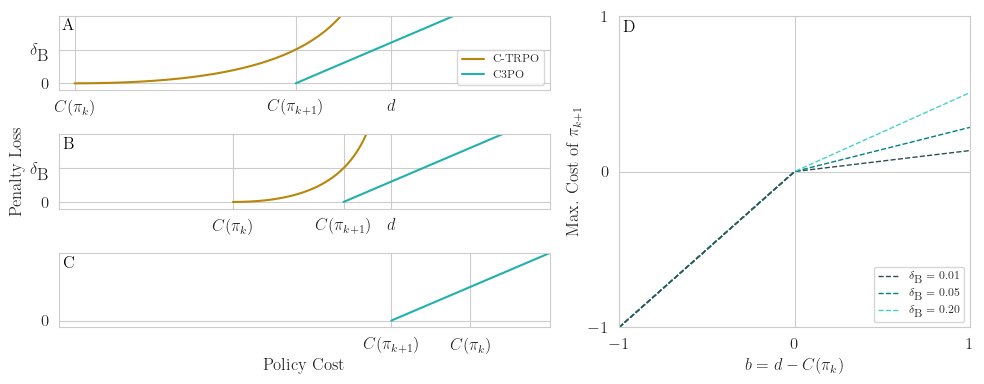

In [79]:
# Helper function used for visualization in the following examples
def identify_axes(ax_dict, fontsize=12, color="black"):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : dict[str, Axes]
        Mapping between the title / label and the Axes.
    fontsize : int, optional
        How big the label should be.
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="black")
    for k, ax in ax_dict.items():
        if k == "D":
            ax.text(0.03, 0.96, k, transform=ax.transAxes, **kw)
        else:
            ax.text(0.02, 0.86, k, transform=ax.transAxes, **kw)

mosaic = """
    AAAADDD
    BBBBDDD
    CCCCDDD
"""
fig = plt.figure(layout="constrained", figsize=(10, 4))
ax_dict = fig.subplot_mosaic(mosaic)

from scipy.special import lambertw

def budget_function(b, alpha):
    x = b*(lambertw(-np.exp(-alpha-1))+1)
    return np.minimum(b, x)

def budget_function_2(b, alpha):
    return np.sqrt(2*b*alpha)

x = np.linspace(-1, 1, 500)
for d, c in zip([0.01, 0.050, 0.2], ["darkslategrey", "teal", "mediumturquoise"]):
    ax_dict["D"].plot(x, budget_function(x, d), label=r"$\delta_\textup{B}={%.2f}$" % d, color=c, linestyle="dashed", linewidth=1)
    ax_dict["D"].plot(np.linspace(-1, 0, 250), np.linspace(-1, 0, 250), color="darkslategrey", linestyle="dashed", linewidth=1)

ax_dict["D"].legend(loc="lower right", fontsize=8)
ax_dict["D"].set_xlim(-1, 1)
ax_dict["D"].set_ylim(-1, 1)
ax_dict["D"].set_xlabel(r"$b=d-C(\pi_k)$")
ax_dict["D"].set_ylabel(r"Max. Cost of $\pi_{k+1}$")
ax_dict["D"].set_xticks([-1, 0, 1])
ax_dict["D"].set_yticks([-1, 0, 1])

limit = 3
d = 0.5

def d_c_barrier(x):
    return np.log(limit/(limit-x)) - x/limit

def relu(x, a):
    return np.maximum(0, x-a)

for ax, limit in zip([ax_dict["A"], ax_dict["B"], ax_dict["C"]], [2, 1, -0.5]):
    alpha = min(limit, budget_function(limit, d).real)

    if limit > 0:
        x = np.linspace(0, limit-1e-6, 1000)
        ax.plot(x, d_c_barrier(x), label=r"C-TRPO", color="darkgoldenrod")
    else:
        x = np.linspace(0, 0+1e-6, 1000)
        ax.plot(x, np.zeros_like(x), label=r"C-TRPO", color="darkgoldenrod")

    x = np.linspace(alpha, limit+1, 1000)
    ax.plot(x, relu(x, alpha), label=r"C3PO", color="lightseagreen")

    ax.set_xlim(-2.1+limit, limit+1)
    ax.set_ylim(-0.1, d*2)

    if limit > 0:
        ax.set_xticks([0., alpha, limit])
        ax.set_xticklabels([r"$C(\pi_k)$", r"$C(\pi_{k+1})$", r"$d$"])
        ax.set_yticks([0, d])
        ax.set_yticklabels([0, r"$\delta_\textup{B}$"])
    else:
        ax.set_xticks([0., alpha])
        ax.set_xticklabels([r"$C(\pi_k)$", r"$C(\pi_{k+1})$"])
        ax.set_yticks([0])
        ax.set_yticklabels([0])

ax_dict["C"].set_xlabel(r"Policy Cost")
ax_dict["B"].set_ylabel(r"Penalty Loss")

ax_dict["A"].legend(fontsize=8, loc="lower right")

identify_axes(ax_dict)

plt.tight_layout()

plt.savefig("img/func_mosaic.pdf")